In [2]:
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import os 
import time as Time 

from pinnPack.initializer import genData 
from pinnPack.network import physicsNetwork
from pinnPack.optimizer import pinnOptimizer 
from ssfmPack import utils, ssfm

In [3]:
print("GPU available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


GPU available: True
Using device: cuda


# Function Initialization

In [4]:
def sechPulsePINN(time, amplitude, pulsewidth, T): 
    time = time
    return amplitude/np.cosh(time*T/pulsewidth)

def charLength(pulsewidth, beta2):
    return np.pi/2*pulsewidth**2/np.abs(beta2)

def initPulse(time, pulsewidth, beta2, gamma, T):
    A = np.sqrt(np.abs(beta2)/gamma/pulsewidth**2)
    return sechPulsePINN(time, A, pulsewidth, T)

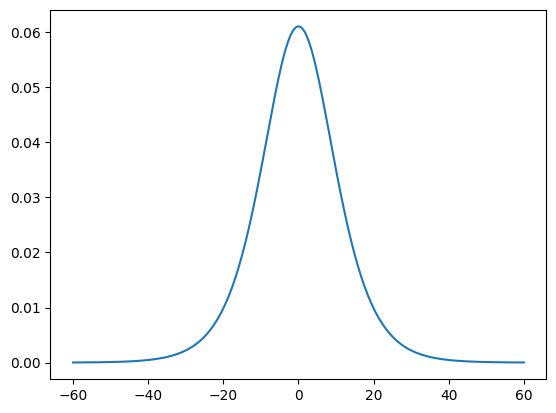

In [4]:
pulsewidth = 0.1*2**7
gamma = 10 
beta2 = -100 
alpha = 0.2*np.log(10)/10 
length = 5*charLength(pulsewidth, beta2)
T = 10*pulsewidth #how about enlarging T?
start_point = np.array([-60/T,0]) #(t,x) = (-1,0)
final_point = np.array([60/T,1]) #(t,x) = (1,1)  

t_array = np.linspace(start_point[0], final_point[0], 256)

plt.plot(t_array*T, np.abs(initPulse(t_array, pulsewidth, beta2, gamma, T))**2)

In [5]:
class pinnModel:
    def __init__(self, col_points, init_label, bound_label, multiplier = 5):
        self.col_points = col_points
        self.init_label = init_label 
        self.bound_label = bound_label
        
        self.pulsewidth = 0.1*2**7
        self.gamma = 10 
        self.beta2 = -100 
        self.alpha = 0.2*np.log(10)/10 
        self.length = multiplier*charLength(self.pulsewidth, self.beta2)
        self.T = 10*self.pulsewidth #how about enlarging T?
        
        self.label_data, self.col_data = self.generate_data(col_points, init_label, bound_label)
        
    def generate_data(self, col_points, init_label, bound_label): 
        start_point = np.array([-1,0]) #(t,x) = (-1,0)
        final_point = np.array([1,1]) #(t,x) = (1,1) 

        t_initial = genData.generate_points(final_point[0], start_point[0], init_label)
        x_boundary = genData.generate_points(final_point[-1], start_point[-1], bound_label)

        #IC (x = 0) 
        init_tx = np.c_[t_initial, 
                        np.zeros((init_label, 1))]
        u_init = initPulse(init_tx[...,0], self.pulsewidth, self.beta2, self.gamma, self.T).reshape(-1,1)
        init_uv = np.c_[u_init, np.zeros_like(u_init)] 

        #lower BC (t = t_init) 
        lower_tx = np.c_[np.full((bound_label, 1), start_point[0]), x_boundary]
        lower_uv = np.zeros((bound_label, 2))

        #upper BC (t = t_f) 
        upper_tx = np.c_[np.full((bound_label, 1), final_point[0]), x_boundary] 
        upper_uv = np.zeros((bound_label, 2))

        #labelled point
        label_point = np.concatenate([init_tx, lower_tx, upper_tx]) 
        label_uv = np.concatenate([init_uv, lower_uv, upper_uv]) 
        #collocation point 
        col_point = genData.generate_points(final_point, start_point, col_points)
        col_uv = np.zeros((col_points, 2))

        #batch data 
        label_data = genData.batch_data(label_point, label_uv)
        col_data = genData.batch_data(col_point, col_uv)

        return label_data, col_data
    
    
    def runProgs(self, model_name, layers, activation, adam_epochs, lbfgs_epochs, t_dim, z_dim):
        model = physicsNetwork(layers = layers, activation = activation)
        optimizer = pinnOptimizer(model, self.col_data, self.label_data, 
                                  self.T, self.length, self.alpha, self.beta2, self.gamma)
        
        optimizer.fit(adam_epochs, lbfgs_epochs)
        
        #Inference 
        start_point = np.array([-1,0]) #(t,x) = (-1,0)
        final_point = np.array([1,1]) #(t,x) = (1,1)  
        
        t_array = np.linspace(start_point[0], final_point[0], t_dim)
        z_array = np.linspace(start_point[1], final_point[1], z_dim)
        T_matrices, Z_matrices = np.meshgrid(t_array, z_array) 
        tZ = np.stack((T_matrices.flatten(), Z_matrices.flatten()), axis = -1)
        tZ = torch.tensor(tZ, dtype=torch.float32)
        
        start = Time.time()
        
        model.eval()  
        with torch.no_grad():  
            prediction = model(tZ)
        result = (prediction[:,0] + 1j*prediction[:,1]).cpu().numpy()
        result = result.reshape(T_matrices.shape)
        
        stop = Time.time()
        
        if not os.path.exists(f'result/pinn/{model_name}'):
            os.mkdir(f'result/pinn/{model_name}')
            
        imgpath = f'result/pinn/{model_name}/result.png'
        recordpath = f'result/pinn/{model_name}/record.png'
        jsonpath = 'result/pinn/report.json'
        utils.plotPulseContour(Z_matrices*self.length, T_matrices*self.T, result, imgpath)
        utils.plotLine(optimizer.loss_records, optimizer.time_records, recordpath)
        
        #Record Data 
        data = {
            'time': self.T,
            'inference_time': stop-start,
            'length': self.length,
            'col_points': self.col_points, 
            'init_label': self.init_label, 
            'bound_label': self.bound_label, 
            'layers': layers, 
            'activation': activation,
            'adam_epochs': adam_epochs, 
            'lbfgs_epochs': lbfgs_epochs,
            'loss_records': [i for i in optimizer.loss_records],
            'runtime_records':[i for i in optimizer.time_records]
        }
        utils.updateJSON(model_name, data, jsonpath)
        
        return result
        
        


# PINN (1)

Processing using ADAM Optimalization strategies
Training Loss: 3.2980e-04 for Epoch 10
Training Loss: 2.8072e-04 for Epoch 20
Training Loss: 2.6644e-04 for Epoch 30
Training Loss: 2.3108e-04 for Epoch 40
Training Loss: 2.0817e-04 for Epoch 50
Training Loss: 1.8508e-04 for Epoch 60
Training Loss: 1.6277e-04 for Epoch 70
Training Loss: 1.6500e-04 for Epoch 80
Processing using L-BFGS Optimalization strategies
Training Loss: 2.5983e-05 for LBGFS Operation
Data Updated!


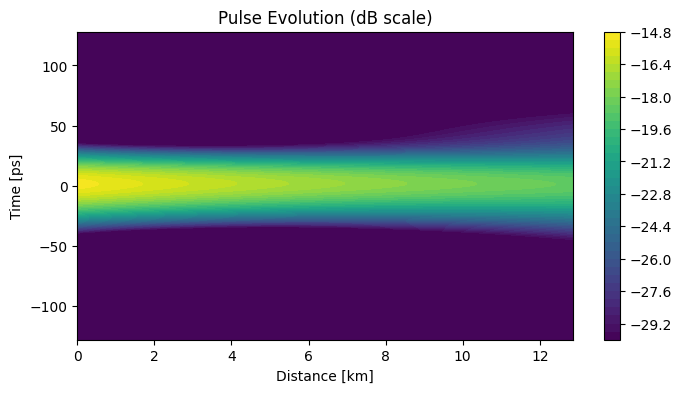

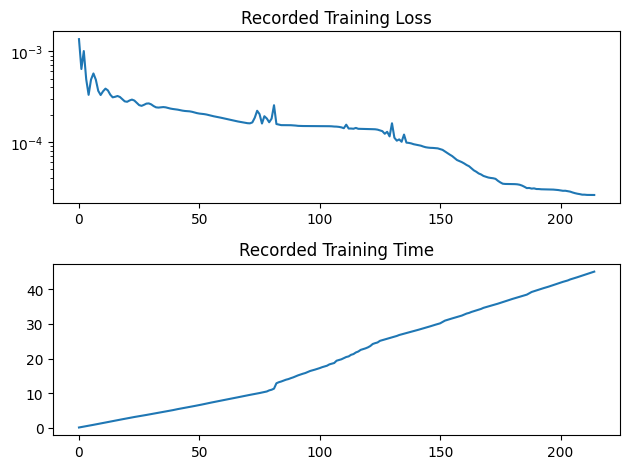

In [10]:
thisModel = pinnModel(col_points = 5000, init_label = 100, bound_label = 500)

layers = [64,64,64,64,64]
activation = 'tanh'
adam_epochs = 80
lbfgs_epochs = 120
model_name = f'PINN-{activation}-adam{adam_epochs}lbfgs{lbfgs_epochs}'

result = thisModel.runProgs(model_name = model_name, layers = layers, activation = activation, 
                   adam_epochs = adam_epochs, lbfgs_epochs = lbfgs_epochs,
                   t_dim = 240, z_dim = 4096)
                      

# PINN (2)

Processing using ADAM Optimalization strategies
Training Loss: 3.2980e-04 for Epoch 10
Training Loss: 2.8072e-04 for Epoch 20
Training Loss: 2.6644e-04 for Epoch 30
Training Loss: 2.3108e-04 for Epoch 40
Training Loss: 2.0817e-04 for Epoch 50
Training Loss: 1.8508e-04 for Epoch 60
Training Loss: 1.6277e-04 for Epoch 70
Training Loss: 1.6500e-04 for Epoch 80
Training Loss: 1.5707e-04 for Epoch 90
Training Loss: 1.5357e-04 for Epoch 100
Training Loss: 1.5034e-04 for Epoch 110
Training Loss: 1.5023e-04 for Epoch 120
Training Loss: 1.4952e-04 for Epoch 130
Training Loss: 1.4920e-04 for Epoch 140
Training Loss: 1.4896e-04 for Epoch 150
Training Loss: 1.4876e-04 for Epoch 160
Training Loss: 1.4859e-04 for Epoch 170
Training Loss: 1.4841e-04 for Epoch 180
Training Loss: 1.4823e-04 for Epoch 190
Training Loss: 1.4803e-04 for Epoch 200
Processing using L-BFGS Optimalization strategies
Training Loss: 1.4801e-04 for LBGFS Operation
Data Updated!


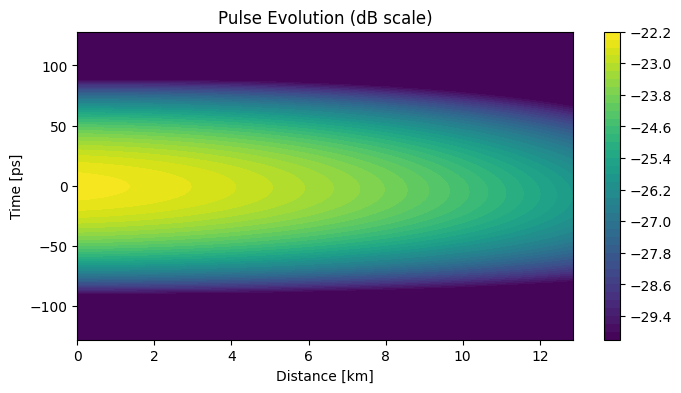

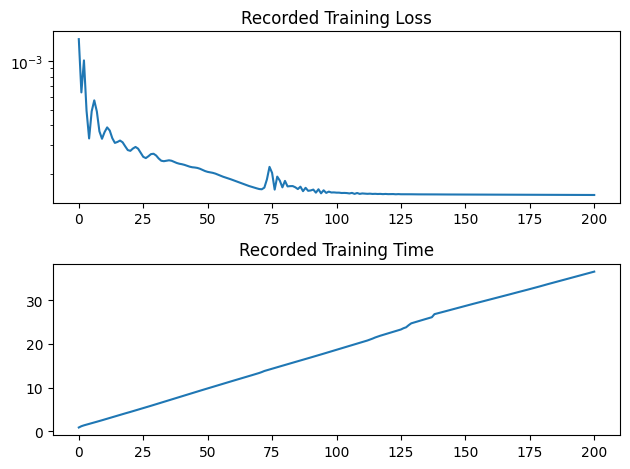

In [11]:
thisModel = pinnModel(col_points = 5000, init_label = 100, bound_label = 500)

layers = [64,64,64,64,64]
activation = 'tanh'
adam_epochs = 200
lbfgs_epochs = 0
model_name = f'PINN-{activation}-adam{adam_epochs}lbfgs{lbfgs_epochs}'

result = thisModel.runProgs(model_name = model_name, layers = layers, activation = activation, 
                   adam_epochs = adam_epochs, lbfgs_epochs = lbfgs_epochs,
                   t_dim = 128, z_dim = 512)
                      

# PINN (3)

Processing using ADAM Optimalization strategies
Processing using L-BFGS Optimalization strategies
Training Loss: 4.3697e-05 for LBGFS Operation
Data Updated!


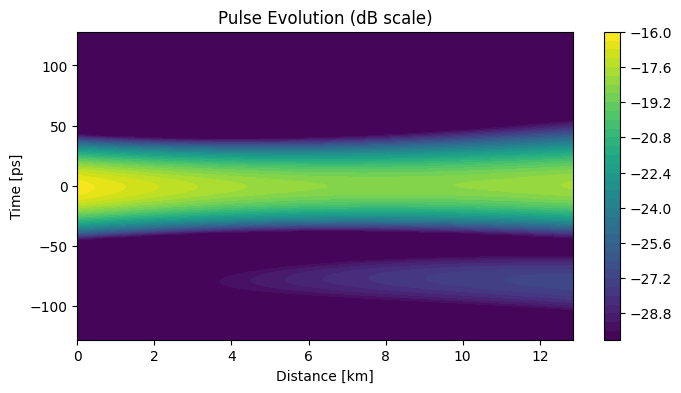

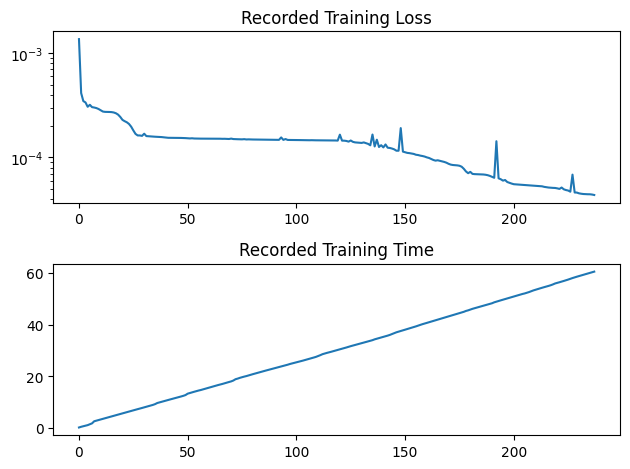

In [13]:
thisModel = pinnModel(col_points = 5000, init_label = 100, bound_label = 500)

layers = [64,64,64,64,64]
activation = 'tanh'
adam_epochs = 0
lbfgs_epochs = 200
model_name = f'PINN-{activation}-adam{adam_epochs}lbfgs{lbfgs_epochs}'

result = thisModel.runProgs(model_name = model_name, layers = layers, activation = activation, 
                   adam_epochs = adam_epochs, lbfgs_epochs = lbfgs_epochs,
                   t_dim = 128, z_dim = 512)
                      

# PINN (4)

Processing using ADAM Optimalization strategies
Training Loss: 5.5862e-04 for Epoch 10
Training Loss: 3.2249e-04 for Epoch 20
Training Loss: 2.6991e-04 for Epoch 30
Training Loss: 2.4741e-04 for Epoch 40
Training Loss: 2.3673e-04 for Epoch 50
Training Loss: 2.2199e-04 for Epoch 60
Training Loss: 2.0465e-04 for Epoch 70
Training Loss: 1.8576e-04 for Epoch 80
Processing using L-BFGS Optimalization strategies
Training Loss: 3.1091e-05 for LBGFS Operation
Data Updated!


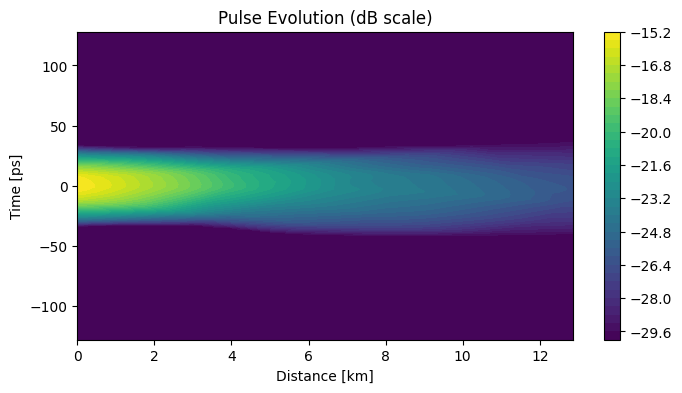

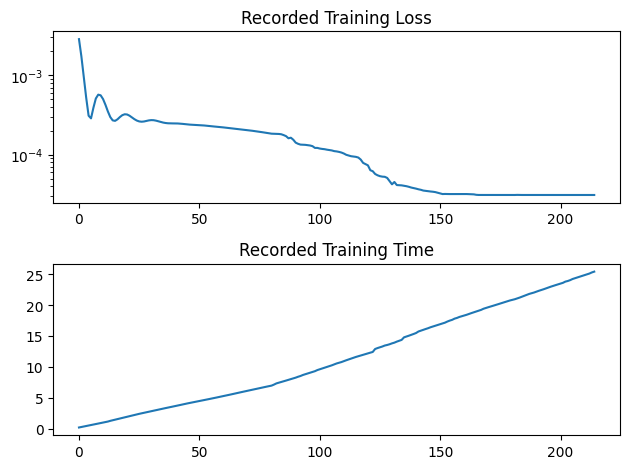

In [6]:
thisModel = pinnModel(col_points = 5000, init_label = 100, bound_label = 500)

layers = [64,64,64,64,64]
activation = 'relu'
adam_epochs = 80
lbfgs_epochs = 120
model_name = f'PINN-{activation}-adam{adam_epochs}lbfgs{lbfgs_epochs}'

result = thisModel.runProgs(model_name = model_name, layers = layers, activation = activation, 
                   adam_epochs = adam_epochs, lbfgs_epochs = lbfgs_epochs,
                   t_dim = 128, z_dim = 512)
                      

# PINN (5)

Processing using ADAM Optimalization strategies
Training Loss: 6.2370e-04 for Epoch 10
Training Loss: 2.8789e-04 for Epoch 20
Training Loss: 2.8300e-04 for Epoch 30
Training Loss: 2.8187e-04 for Epoch 40
Training Loss: 2.6740e-04 for Epoch 50
Training Loss: 2.6163e-04 for Epoch 60
Training Loss: 2.5862e-04 for Epoch 70
Training Loss: 2.5495e-04 for Epoch 80
Processing using L-BFGS Optimalization strategies
Training Loss: 1.2653e-04 for LBGFS Operation
Data Updated!


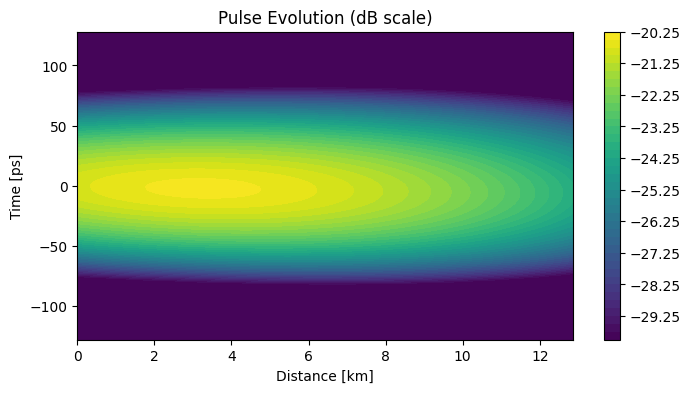

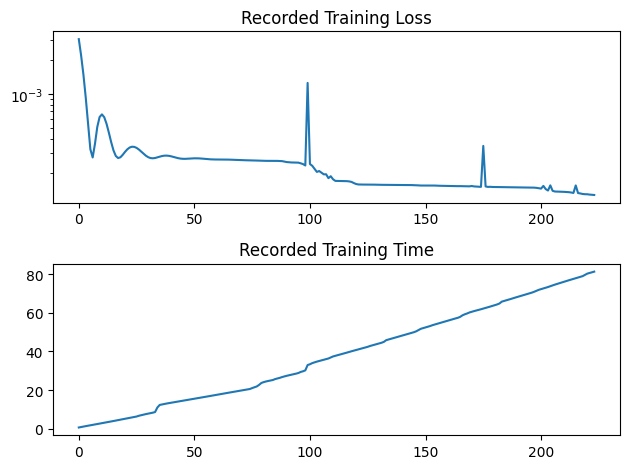

In [7]:
thisModel = pinnModel(col_points = 5000, init_label = 100, bound_label = 500)

layers = [64,64,64,64,64]
activation = 'swish'
adam_epochs = 80
lbfgs_epochs = 120
model_name = f'PINN-{activation}-adam{adam_epochs}lbfgs{lbfgs_epochs}'

result = thisModel.runProgs(model_name = model_name, layers = layers, activation = activation, 
                   adam_epochs = adam_epochs, lbfgs_epochs = lbfgs_epochs,
                   t_dim = 128, z_dim = 512)